In [2]:
import re
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import datetime as dt
from collections import Counter

import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [3]:
df = pd.read_csv(r'C:\Documents\Courses\Sem3\SMDM\Project\Code\Biden_No_Retweet_Full_Text_After_Election.csv')

In [4]:
df.head()

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets
0,2022-05-08 23:58:20+00:00,1523452270448635905,False,The fact that #BethSentUs doxxed the justices ...,SanFranSooner,NaN,Twitter for iPhone,3,285,561,2
1,2022-05-08 23:57:33+00:00,1523452076147179520,False,Trump complained US Navy ships ‘look ugly’: Es...,MartinJmcmah,NaN,Twitter for iPhone,2,1213,179,0
2,2022-05-08 23:56:51+00:00,1523451899659251712,False,Remember when #biden left Afghanistan? Why isn...,christjiminy1,NaN,Twitter for iPhone,0,8,67,0
3,2022-05-08 23:55:50+00:00,1523451642909061121,False,"#Biden is asking for a $813,000,000,000 ""defen...",joshuamills044,NaN,Twitter for Android,0,662,1089,0
4,2022-05-08 23:53:44+00:00,1523451115479924741,False,"@ArseGrammatica Last month, the #SCOTUS reject...",hollmic,"Kansas, USA",Twitter Web App,0,89,427,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13658 entries, 0 to 13657
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       13658 non-null  object
 1   Tweet_id   13658 non-null  int64 
 2   Verified   13658 non-null  bool  
 3   Tweet      13658 non-null  object
 4   User       13658 non-null  object
 5   Location   9021 non-null   object
 6   Source     13658 non-null  object
 7   Likes      13658 non-null  int64 
 8   Followers  13658 non-null  int64 
 9   Following  13658 non-null  int64 
 10  Retweets   13658 non-null  int64 
dtypes: bool(1), int64(5), object(5)
memory usage: 1.1+ MB


In [6]:
df.shape

(13658, 11)

Preprocessing

In [7]:
df['Date'] = df['Date'].apply(lambda x: x[:-6] if '+' in x else x)
df.head()

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets
0,2022-05-08 23:58:20,1523452270448635905,False,The fact that #BethSentUs doxxed the justices ...,SanFranSooner,NaN,Twitter for iPhone,3,285,561,2
1,2022-05-08 23:57:33,1523452076147179520,False,Trump complained US Navy ships ‘look ugly’: Es...,MartinJmcmah,NaN,Twitter for iPhone,2,1213,179,0
2,2022-05-08 23:56:51,1523451899659251712,False,Remember when #biden left Afghanistan? Why isn...,christjiminy1,NaN,Twitter for iPhone,0,8,67,0
3,2022-05-08 23:55:50,1523451642909061121,False,"#Biden is asking for a $813,000,000,000 ""defen...",joshuamills044,NaN,Twitter for Android,0,662,1089,0
4,2022-05-08 23:53:44,1523451115479924741,False,"@ArseGrammatica Last month, the #SCOTUS reject...",hollmic,"Kansas, USA",Twitter Web App,0,89,427,0


In [8]:
df['Date'] = df['Date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')) #Convert to date time format

In [9]:
df.isnull().sum()

Date            0
Tweet_id        0
Verified        0
Tweet           0
User            0
Location     4637
Source          0
Likes           0
Followers       0
Following       0
Retweets        0
dtype: int64

In [10]:
df['Source'].value_counts()

Twitter Web App        4930
Twitter for iPhone     3811
Twitter for Android    2896
Twitter for iPad        517
Valurank                354
                       ... 
eClincher                 1
Infokalyptisch            1
The Tweeted Times         1
SocialChamp IO            1
Bot Sentinel              1
Name: Source, Length: 119, dtype: int64

In [11]:
df['Location'].nunique()

2490

In [12]:
tweets_list = df['Tweet'].tolist()
len(tweets_list)

13658

In [13]:
tweets_list_updated = set(tweets_list)
len(tweets_list_updated)

13525

In [14]:
tweets_list_updated  = list(tweets_list_updated)
type(tweets_list_updated)

list

In [15]:
df['Tweet'].duplicated().sum()

133

In [16]:
df = df.drop_duplicates(subset = 'Tweet', keep = 'first',ignore_index = True)
df.shape

(13525, 11)

In [17]:
df['Tweet'].duplicated().sum()

0

removing emojis

In [18]:
def remove_emoji(tweet):
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', tweet)

df['Processed_Tweet']=df.Tweet.apply(remove_emoji)

In [19]:
count = 0
for i in df['Processed_Tweet']:
    if re.match(r'^RT', i):  #remove any rows that contain RT
        df.drop(df.loc[df['Processed_Tweet']==i].index,inplace = True)
        count+=1
    
count

0

removing retweets that is the tweet which has RT

In [20]:
df['Processed_Tweet'] = [re.sub('^RT[\s]','',i) for i in df['Processed_Tweet']]  #Remove RT substring

In [21]:
df['Processed_Tweet']

0        The fact that #BethSentUs doxxed the justices ...
1        Trump complained US Navy ships ‘look ugly’: Es...
2        Remember when #biden left Afghanistan? Why isn...
3        #Biden is asking for a $813,000,000,000 "defen...
4        @ArseGrammatica Last month, the #SCOTUS reject...
                               ...                        
13520    Voldemort is back!\n\n** This post has been fl...
13521    #Biden will have to either #boycott #G20Indone...
13522    Ex-#Biden aide Francis Person went to White Ho...
13523    @GOP:\nDid #Biden compromise national security...
13524    @CBSMornings Only fools do not believe in the ...
Name: Processed_Tweet, Length: 13525, dtype: object

removing usernames and urls

In [22]:
df['Processed_Tweet'] = [re.sub('@[^\s]+', ' ', i) for i in df['Processed_Tweet']] #remove usernames
df['Processed_Tweet'] = [re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', i) for i in df['Processed_Tweet']] #Remove urls

removing the hashtags symbol from the tweets

In [23]:
df['Processed_Tweet'] = [re.sub(r'#([^\s]+)', r'\1', i) for i in df['Processed_Tweet']] # remove the # in #hashtag

using library to preprocess the tweets

In [24]:
import preprocessor as p #Module for faster preprocessing specifically for tweets
df['Processed_Tweet'] = [p.clean(i) for i in df['Processed_Tweet']]
df['Processed_Tweet']

0        The fact that BethSentUs doxxed the justices w...
1        Trump complained US Navy ships look ugly: Espe...
2        Remember when biden left Afghanistan? Why isnt...
3        Biden is asking for a $813,000,000,000 "defens...
4        Last month, the SCOTUS rejected the Biden admi...
                               ...                        
13520    Voldemort is back!** This post has been flagge...
13521    Biden will have to either boycott G20Indonesia...
13522    Ex-Biden aide Francis Person went to White Hou...
13523    Did Biden compromise national security by gree...
13524    Only fools do not believe in the possibility o...
Name: Processed_Tweet, Length: 13525, dtype: object

In [25]:
#removing unnecessary special characters, numbers, punctuations in tweets
df.Processed_Tweet = df.Processed_Tweet.str.replace("[^a-zA-Z]", " ")

C:\Users\kanak\AppData\Local\Temp\ipykernel_14940\1181258175.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df.Processed_Tweet = df.Processed_Tweet.str.replace("[^a-zA-Z]", " ")


In [26]:
df.Processed_Tweet = [low.lower() for low in df.Processed_Tweet] #Converting into lower case 
df.Processed_Tweet =  df.Processed_Tweet.str.replace("amp", "")

In [27]:
df['Processed_Tweet'][12] #Sample tweet

'blame biden fauci for childrens mentalhealth masksisolation in homes  mins nbc'

Exploratory data analysis

In [28]:
df['User'].value_counts()

valurank           354
kk131066           197
AdorateJesus       125
RethinkingEve      105
dreyfus_michael     89
                  ... 
hamid43542842        1
TryNPuma             1
Conscie_             1
ChukwumaOdelugo      1
ttstrac              1
Name: User, Length: 6182, dtype: int64

In [29]:
df.query('User == "valurank"').Processed_Tweet.tolist()

['content analysis this article scores       the complete report can be viewed here   i m a bot president biden',
 'content analysis this article scores       the complete report can be viewed here   i m a bot biden centern',
 'content analysis this article scores       the complete report can be viewed here   i m a bot biden strategie',
 'content analysis this article scores       the complete report can be viewed here   i m a bot ukraine biden',
 'content analysis this article scores       the complete report can be viewed here   i m a bot ukraine biden',
 'content analysis this article scores       the complete report can be viewed here   i m a bot     mules clinton russia biden',
 'content analysis this article scores       the complete report can be viewed here   i m a bot president biden',
 'content analysis this article scores       the complete report can be viewed here   i m a bot president biden',
 'content analysis this article scores       the complete report can be viewed 

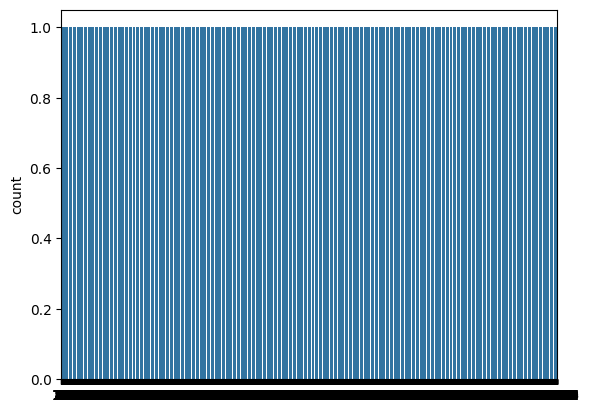

In [30]:
bar = sns.countplot(df['Verified'])

In [31]:
df['Verified'].value_counts()

False    13193
True       332
Name: Verified, dtype: int64

In [32]:
df_verified = df.query('Verified == True')

In [33]:
df_verified['User'].value_counts()

DevonHeinen        33
DickMorrisTweet     8
BastianBrauns       8
arabnews            7
natlawreview        7
                   ..
matisaksk           1
mrglenn             1
CGTNGraphics        1
khaleejtimes        1
ATParasiliti        1
Name: User, Length: 164, dtype: int64

In [34]:
df_verified.query('User == "BastianBrauns"').Processed_Tweet.tolist()

['but so why then is she still there  biden whcd correspondentsdinner',
 'biden to trevornoah   now you gonna roast the president of the united states  and unlike in moscow you won t go to jail   biden whcd correspondentsdinner',
 'last sentence honoring albright   by the way madeleine albright was right  we are the indispensable nation  biden whcd correspondentsdinner',
 ' republicans seem to support one fellow  some guy named brandon  he s having a really good year  and i m kind of happy for him   letsgobrandon biden whcd correspondentsdinner',
 ' i told my grandkids and they could stay up late and watch this show tonight  biden whcd correspondentsdinner',
 'theres nothing i can say about the gop that kevin mccarthy hasnt already put on tape  biden whcd correspondentsdinner',
 ' just contact your favorite fox news reporter  vaccinated and boosted  all of them  biden whcd correspondentsdinner',
 'biden first take against trump at correspondentsdinner   this is the first time a preside

In [35]:
days = df['Date'].dt.day.tolist()
no_of_days = Counter(days)
no_of_days

Counter({8: 1160,
         7: 1273,
         6: 1526,
         5: 1625,
         4: 1684,
         3: 1371,
         2: 1700,
         1: 1651,
         30: 1447,
         29: 88})

Text(0.5, 1.0, 'Count Of Extracted Tweets On Each Day')

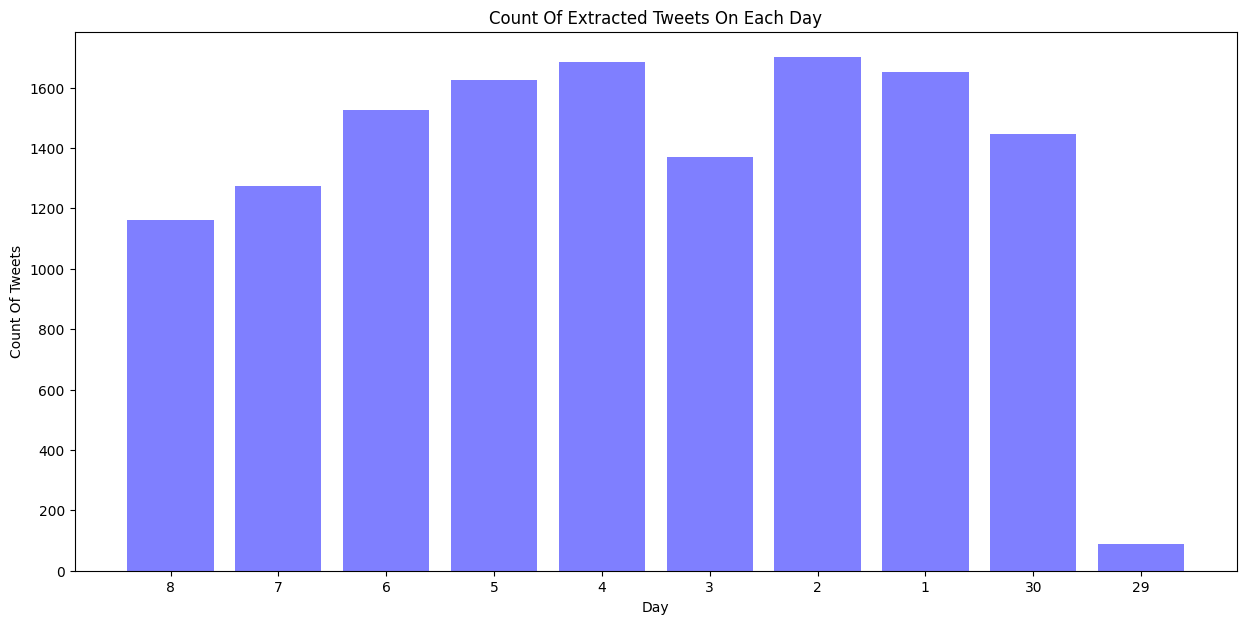

In [36]:
fig = plt.figure(figsize = (15,7))
plt.bar(range(len(no_of_days)), list(no_of_days.values()), align='center', alpha = 0.5,color = 'blue')
plt.xticks(range(len(no_of_days)), list(no_of_days.keys()))
plt.xlabel("Day")
plt.ylabel("Count Of Tweets")
plt.title("Count Of Extracted Tweets On Each Day")

In [37]:
hours = df['Date'].dt.hour.tolist()

In [38]:
no_of_hours = Counter(hours)
no_of_hours

Counter({23: 764,
         22: 610,
         21: 656,
         20: 694,
         19: 775,
         18: 689,
         17: 694,
         16: 756,
         15: 853,
         14: 747,
         13: 761,
         12: 634,
         11: 521,
         10: 333,
         9: 312,
         8: 267,
         7: 299,
         6: 292,
         5: 316,
         4: 404,
         3: 470,
         2: 546,
         1: 526,
         0: 606})

Text(0.5, 1.0, 'Count Of Extracted Tweets On Each Hour')

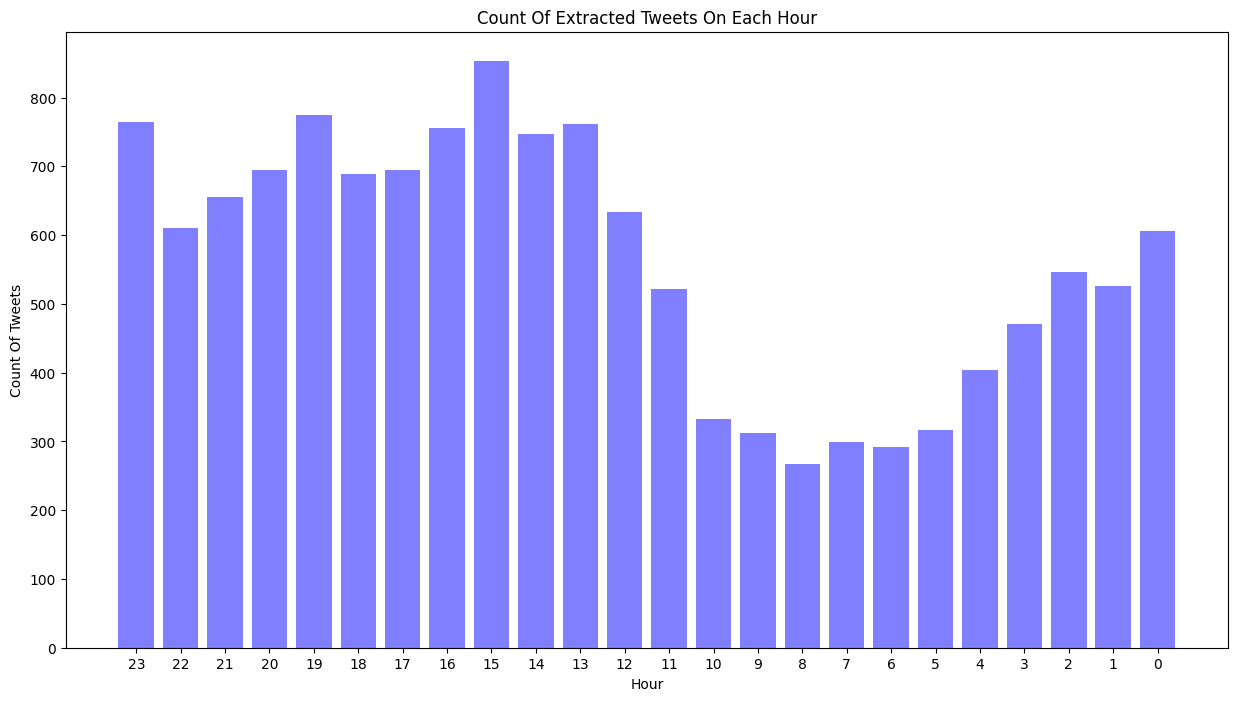

In [39]:
fig = plt.figure(figsize = (15,8))
plt.bar(range(len(no_of_hours)), list(no_of_hours.values()), align='center', alpha = 0.5,color = 'blue')
plt.xticks(range(len(no_of_hours)), list(no_of_hours.keys()))
plt.xlabel("Hour")
plt.ylabel("Count Of Tweets")
plt.title("Count Of Extracted Tweets On Each Hour")

In [40]:
from wordcloud import WordCloud
tokenizer = TweetTokenizer()


In [41]:
stop_words = set(stopwords.words('english')) 
stop_words = list(stop_words)
print(stop_words) #removing stopwords

['out', 'these', 'myself', 'she', 'here', 'with', 'yours', "won't", 'only', 'those', 'll', 'mightn', 'them', 'from', "needn't", "that'll", 'couldn', 'while', 're', 'theirs', "isn't", 'will', 'in', 'his', 'some', "wasn't", 'same', 'down', 'for', 'we', 'then', 'they', 'having', 'again', 'was', 'at', 'to', "doesn't", 'off', 'y', 'hers', "she's", 'haven', "shouldn't", 'or', "aren't", 'hadn', 'don', 'because', 'as', 'now', 'hasn', 'not', 'aren', 'd', 'of', 'more', 'my', 'had', "you'll", 'under', 'once', 'why', 'been', 'should', "wouldn't", 'doing', 'me', 'further', 'up', 'on', 'himself', 'itself', 'few', 'very', 'm', "you'd", 'themselves', 'being', 'but', 'is', 'are', 'how', "didn't", 'her', 'if', 'when', 'no', 'be', 'an', "mightn't", 'shouldn', 'do', 'yourself', 'ours', 'both', 'who', 'ma', 'needn', 'it', 'were', 'between', 'ain', 'weren', 'by', 'you', "hasn't", 'such', 'he', 'has', 'this', 'the', 'i', "mustn't", "should've", 'shan', 'o', 'a', 'does', 'during', 'am', 'over', "it's", 'your'

In [42]:
df['Processed_Tweet'] = df.Processed_Tweet.apply(lambda x: ' '.join(w for w in x.split() if w not in stop_words))   #Remove stopwords

In [43]:
df['Processed_Tweet'] = df['Processed_Tweet'].apply(lambda x: tokenizer.tokenize(x))

In [44]:
#stemming
def lemmatize_stemming(text):
    stemmer=PorterStemmer()
    return stemmer.stem(text)

In [45]:
df['Processed_Tweet'] = df['Processed_Tweet'].apply(lambda x: [lemmatize_stemming(i) for i in x]) # stemming

In [46]:
df['Processed_Tweet'] = df.Processed_Tweet.apply(lambda x: [i for i in x if len(i)>2])

In [47]:
df

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet
0,2022-05-08 23:58:20,1523452270448635905,False,The fact that #BethSentUs doxxed the justices ...,SanFranSooner,NaN,Twitter for iPhone,3,285,561,2,"[fact, bethsentu, dox, justic, bad, enough, bi..."
1,2022-05-08 23:57:33,1523452076147179520,False,Trump complained US Navy ships ‘look ugly’: Es...,MartinJmcmah,NaN,Twitter for iPhone,2,1213,179,0,"[trump, complain, navi, ship, look, ugli, espe..."
2,2022-05-08 23:56:51,1523451899659251712,False,Remember when #biden left Afghanistan? Why isn...,christjiminy1,NaN,Twitter for iPhone,0,8,67,0,"[rememb, biden, left, afghanistan, isnt, bigge..."
3,2022-05-08 23:55:50,1523451642909061121,False,"#Biden is asking for a $813,000,000,000 ""defen...",joshuamills044,NaN,Twitter for Android,0,662,1089,0,"[biden, ask, defens, budget, children, uniteds..."
4,2022-05-08 23:53:44,1523451115479924741,False,"@ArseGrammatica Last month, the #SCOTUS reject...",hollmic,"Kansas, USA",Twitter Web App,0,89,427,0,"[last, month, scotu, reject, biden, administr,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
13520,2022-04-29 22:47:06,1520172853454323712,False,Voldemort is back!\n\n** This post has been fl...,2DIEisGAIN82,NaN,Twitter for iPhone,0,75,291,0,"[voldemort, back, post, flag, misinform, biden..."
13521,2022-04-29 22:46:23,1520172674709954560,False,#Biden will have to either #boycott #G20Indone...,besthealthyou,Planet Earth,Twitter Web App,0,427,62,0,"[biden, either, boycott, indonesia, mayb, zoom..."
13522,2022-04-29 22:44:43,1520172254700703744,False,Ex-#Biden aide Francis Person went to White Ho...,livlifealliance,The Beautiful USA,Twitter for Android,0,17,140,0,"[biden, aid, franci, person, went, white, hous..."
13523,2022-04-29 22:44:39,1520172237562728448,False,@GOP:\nDid #Biden compromise national security...,ttstrac,America,Twitter for iPhone,0,5130,5504,0,"[biden, compromis, nation, secur, green, light..."


modifying the tweets to feed them into the model

In [48]:
texts = []
texts = df.Processed_Tweet.apply(lambda x: [i for i in x] )

In [49]:
all_words = []
for i in texts:
    all_words.append(" ".join(i))

In [50]:
text = []
for i in texts:
    for j in i:
        text.append(j)

In [51]:
len(text)

216667

In [52]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(' '.join(text))

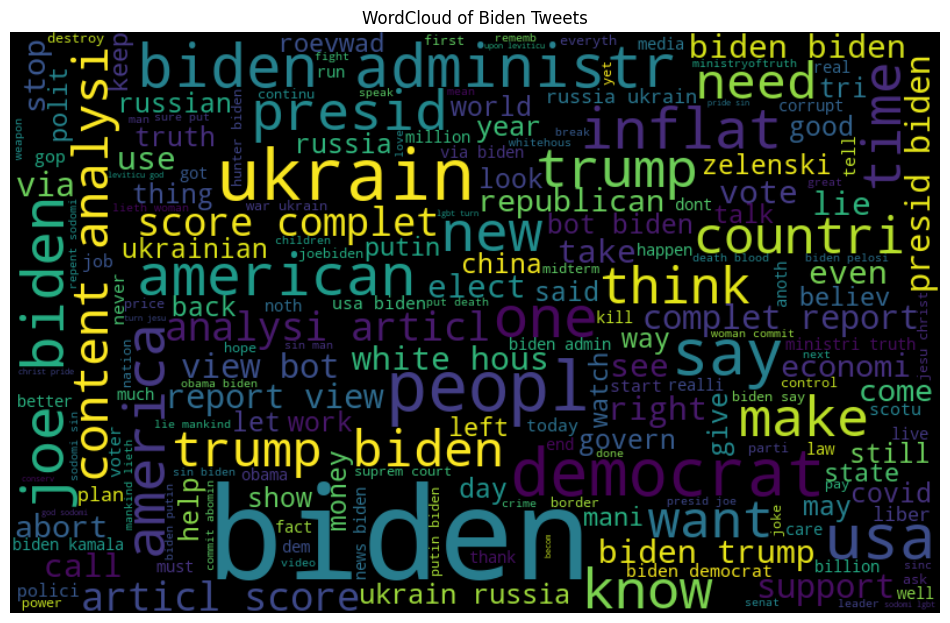

In [53]:
plt.figure(figsize = (12, 12), facecolor="None") 
plt.imshow(wordcloud,interpolation='bilinear') 
plt.axis("off") 
plt.title("WordCloud of Biden Tweets")
plt.show()

SENTIMENT ANALYSIS

In [54]:
from textblob import TextBlob

In [55]:
pol=[]
for Tweet in all_words:
    blob = TextBlob(Tweet)
    pol.append(blob.sentiment.polarity)

In [56]:
len(pol)

13525

In [57]:
len(text)

216667

In [58]:
df['Processed_Tweet']

0        [fact, bethsentu, dox, justic, bad, enough, bi...
1        [trump, complain, navi, ship, look, ugli, espe...
2        [rememb, biden, left, afghanistan, isnt, bigge...
3        [biden, ask, defens, budget, children, uniteds...
4        [last, month, scotu, reject, biden, administr,...
                               ...                        
13520    [voldemort, back, post, flag, misinform, biden...
13521    [biden, either, boycott, indonesia, mayb, zoom...
13522    [biden, aid, franci, person, went, white, hous...
13523    [biden, compromis, nation, secur, green, light...
13524    [fool, believ, possibl, nuclear, war, ukrainew...
Name: Processed_Tweet, Length: 13525, dtype: object

classifying tweets into positive,negative and neutral

In [59]:
positive=0
negative=0
neutral=0
for i in pol:
    if i>0:
        positive+=1
    elif i<0:
        negative+=1
    else:
        neutral+=1
print("Positive Tweets:",positive)
print("Negative Tweets:",negative)
print("Neutral Tweets",neutral)

Positive Tweets: 4632
Negative Tweets: 2651
Neutral Tweets 6242


In [60]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kanak\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [61]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sentiment_scores= []
for i in all_words:
    sentiment_scores.append([sid.polarity_scores(i)])

In [62]:
value = []
for i in sentiment_scores:
    for dict1 in i:
        value.append(list(dict1.values()))

In [63]:
sentimental_score_df = pd.DataFrame(data = value, columns = ['Negative','Neutral','Positive','Compound'])
sentimental_score_df

,Negative,Neutral,Positive,Compound
0,0.326,0.674,0.000,-0.8481
1,0.217,0.783,0.000,-0.3612
2,0.000,1.000,0.000,0.0000
3,0.212,0.788,0.000,-0.5423
4,0.131,0.631,0.238,0.2960
...,...,...,...,...
13520,0.000,0.827,0.173,0.3182
13521,0.263,0.648,0.089,-0.5106
13522,0.100,0.818,0.082,-0.1280
13523,0.000,0.898,0.102,0.3612


In [64]:
sentimental_score_df['val'] = sentimental_score_df['Compound'].apply(lambda x: 'Neutral' if x == 0 else ('Positive' if x > 0 else 'Negative'))
sentimental_score_df.head()

,Negative,Neutral,Positive,Compound,val
0,0.326,0.674,0.000,-0.8481,Negative
1,0.217,0.783,0.000,-0.3612,Negative
2,0.000,1.000,0.000,0.0000,Neutral
3,0.212,0.788,0.000,-0.5423,Negative
4,0.131,0.631,0.238,0.2960,Positive


<Axes: xlabel='sentiment', ylabel='count'>

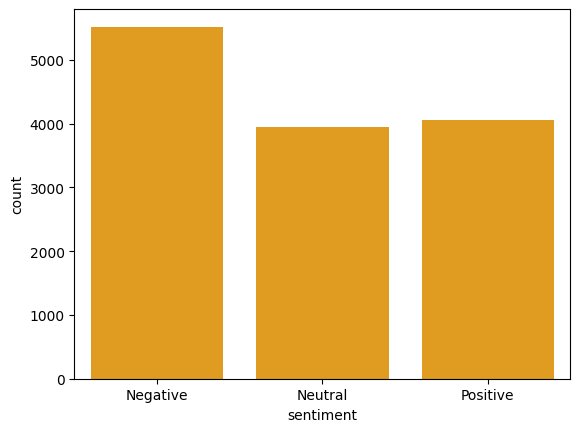

In [65]:
sent_count = pd.DataFrame.from_dict(Counter(sentimental_score_df['val']), orient = 'index').reset_index()
sent_count.columns = ['sentiment', 'count']

sns.barplot(y="count", x='sentiment', data=sent_count , color = 'orange')

In [66]:
filepath = r"C:\Documents\Courses\Sem3\SMDM\Project\Code\NRC Emotion Lexicon.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t')
emolex_df.head(12)
len(emolex_df)

86343

In [67]:
emotions={'positive':0, 'negative':0, 'surprise':0,'sadness':0,
          'anger':0,'joy':0,'negative':0,'trust':0,'fear':0,'anticipation':0,'disgust':0}

In [68]:
word_emotion=dict()
for i in range(0,86343):
    emotion=emolex_df['emotion'][i]
    word=emolex_df['word'][i]
    association=emolex_df['association'][i]
    
    if word not in word_emotion:
        word_emotion[word]=dict()
    word_emotion[word][emotion]=association  

In [69]:
for i in range(0,13525):
    text=df['Tweet'][i]
    for j in text.split():
        if j in word_emotion:
            for k in word_emotion[j]:
                emotions[k]+=word_emotion[j][k]

In [70]:
emotions

{'positive': 5395.0,
 'negative': 5899.0,
 'surprise': 1373.0,
 'sadness': 2651.0,
 'anger': 3138.0,
 'joy': 1913.0,
 'trust': 3427.0,
 'fear': 3507.0,
 'anticipation': 2234.0,
 'disgust': 1895.0}

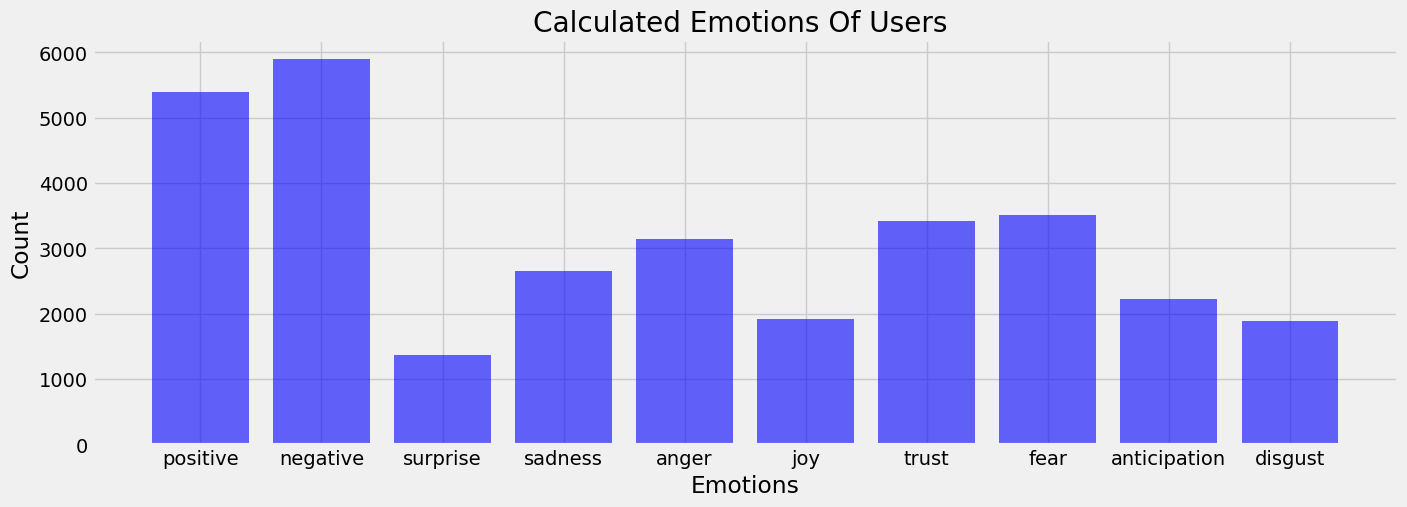

In [71]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [15,5]
plt.bar(list(emotions.keys()),list(emotions.values()),color='blue',alpha = 0.6)
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Calculated Emotions Of Users ')
plt.show()

In [72]:
df.Location  = df.Location.fillna('USA')
f = [i for i in df['Location'] if type(i) != str]
f

[]

In [73]:
df.Location = df.Location.apply(lambda x: x.replace('United States','USA'))
df.Location.value_counts()

USA                       5444
Austin, TX                 359
Kuala Lumpur, Malaysia     197
Portugal                   110
Darien, CT, USA            105
                          ... 
NorthWest England            1
Bavaria, Germany             1
Paris, Ile-de-France         1
Greenville, SC               1
America                      1
Name: Location, Length: 2485, dtype: int64

In [74]:
locations = []
locations_1 = []

locations = [i.split(',')[-1] for i in df['Location']]
locations_1 =  [i.split(',')[0] for i in df['Location']]
df['Processed_Location'] = locations_1
df

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet,Processed_Location
0,2022-05-08 23:58:20,1523452270448635905,False,The fact that #BethSentUs doxxed the justices ...,SanFranSooner,USA,Twitter for iPhone,3,285,561,2,"[fact, bethsentu, dox, justic, bad, enough, bi...",USA
1,2022-05-08 23:57:33,1523452076147179520,False,Trump complained US Navy ships ‘look ugly’: Es...,MartinJmcmah,USA,Twitter for iPhone,2,1213,179,0,"[trump, complain, navi, ship, look, ugli, espe...",USA
2,2022-05-08 23:56:51,1523451899659251712,False,Remember when #biden left Afghanistan? Why isn...,christjiminy1,USA,Twitter for iPhone,0,8,67,0,"[rememb, biden, left, afghanistan, isnt, bigge...",USA
3,2022-05-08 23:55:50,1523451642909061121,False,"#Biden is asking for a $813,000,000,000 ""defen...",joshuamills044,USA,Twitter for Android,0,662,1089,0,"[biden, ask, defens, budget, children, uniteds...",USA
4,2022-05-08 23:53:44,1523451115479924741,False,"@ArseGrammatica Last month, the #SCOTUS reject...",hollmic,"Kansas, USA",Twitter Web App,0,89,427,0,"[last, month, scotu, reject, biden, administr,...",Kansas
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13520,2022-04-29 22:47:06,1520172853454323712,False,Voldemort is back!\n\n** This post has been fl...,2DIEisGAIN82,USA,Twitter for iPhone,0,75,291,0,"[voldemort, back, post, flag, misinform, biden...",USA
13521,2022-04-29 22:46:23,1520172674709954560,False,#Biden will have to either #boycott #G20Indone...,besthealthyou,Planet Earth,Twitter Web App,0,427,62,0,"[biden, either, boycott, indonesia, mayb, zoom...",Planet Earth
13522,2022-04-29 22:44:43,1520172254700703744,False,Ex-#Biden aide Francis Person went to White Ho...,livlifealliance,The Beautiful USA,Twitter for Android,0,17,140,0,"[biden, aid, franci, person, went, white, hous...",The Beautiful USA
13523,2022-04-29 22:44:39,1520172237562728448,False,@GOP:\nDid #Biden compromise national security...,ttstrac,America,Twitter for iPhone,0,5130,5504,0,"[biden, compromis, nation, secur, green, light...",America


In [75]:
df1 = df
df1['sentiment'] = sentimental_score_df['val']
df1.head()

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet,Processed_Location,sentiment
0,2022-05-08 23:58:20,1523452270448635905,False,The fact that #BethSentUs doxxed the justices ...,SanFranSooner,USA,Twitter for iPhone,3,285,561,2,"[fact, bethsentu, dox, justic, bad, enough, bi...",USA,Negative
1,2022-05-08 23:57:33,1523452076147179520,False,Trump complained US Navy ships ‘look ugly’: Es...,MartinJmcmah,USA,Twitter for iPhone,2,1213,179,0,"[trump, complain, navi, ship, look, ugli, espe...",USA,Negative
2,2022-05-08 23:56:51,1523451899659251712,False,Remember when #biden left Afghanistan? Why isn...,christjiminy1,USA,Twitter for iPhone,0,8,67,0,"[rememb, biden, left, afghanistan, isnt, bigge...",USA,Neutral
3,2022-05-08 23:55:50,1523451642909061121,False,"#Biden is asking for a $813,000,000,000 ""defen...",joshuamills044,USA,Twitter for Android,0,662,1089,0,"[biden, ask, defens, budget, children, uniteds...",USA,Negative
4,2022-05-08 23:53:44,1523451115479924741,False,"@ArseGrammatica Last month, the #SCOTUS reject...",hollmic,"Kansas, USA",Twitter Web App,0,89,427,0,"[last, month, scotu, reject, biden, administr,...",Kansas,Positive


In [76]:
df1.to_csv('sentiment_After_Election.csv',index = False)
df1['day'] = df.Date.dt.day
df1.head()

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet,Processed_Location,sentiment,day
0,2022-05-08 23:58:20,1523452270448635905,False,The fact that #BethSentUs doxxed the justices ...,SanFranSooner,USA,Twitter for iPhone,3,285,561,2,"[fact, bethsentu, dox, justic, bad, enough, bi...",USA,Negative,8
1,2022-05-08 23:57:33,1523452076147179520,False,Trump complained US Navy ships ‘look ugly’: Es...,MartinJmcmah,USA,Twitter for iPhone,2,1213,179,0,"[trump, complain, navi, ship, look, ugli, espe...",USA,Negative,8
2,2022-05-08 23:56:51,1523451899659251712,False,Remember when #biden left Afghanistan? Why isn...,christjiminy1,USA,Twitter for iPhone,0,8,67,0,"[rememb, biden, left, afghanistan, isnt, bigge...",USA,Neutral,8
3,2022-05-08 23:55:50,1523451642909061121,False,"#Biden is asking for a $813,000,000,000 ""defen...",joshuamills044,USA,Twitter for Android,0,662,1089,0,"[biden, ask, defens, budget, children, uniteds...",USA,Negative,8
4,2022-05-08 23:53:44,1523451115479924741,False,"@ArseGrammatica Last month, the #SCOTUS reject...",hollmic,"Kansas, USA",Twitter Web App,0,89,427,0,"[last, month, scotu, reject, biden, administr,...",Kansas,Positive,8


<Axes: xlabel='day', ylabel='count'>

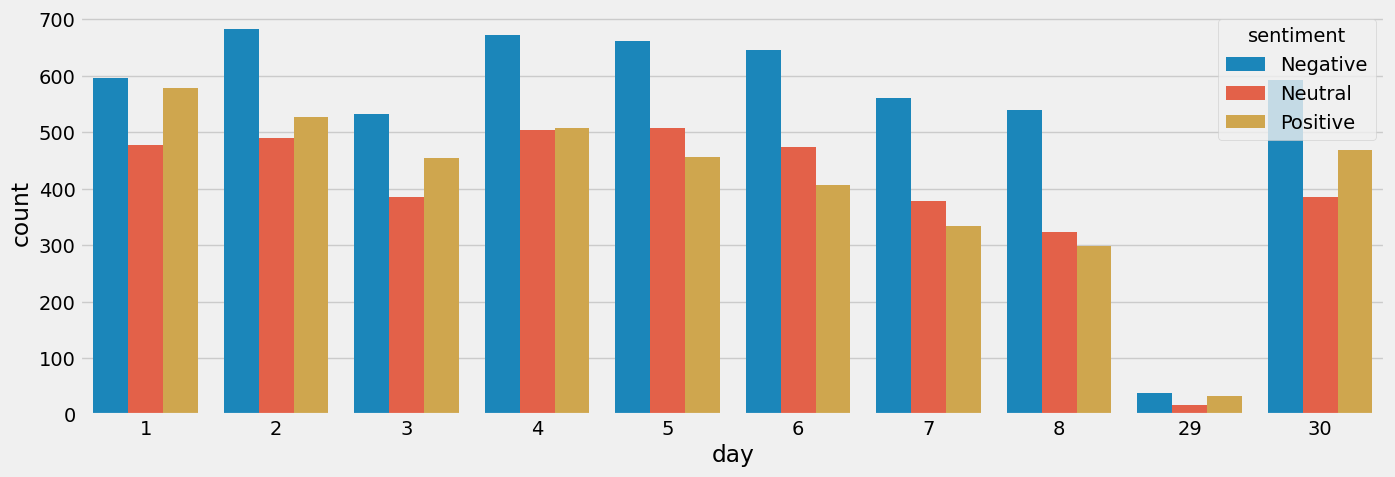

In [77]:
sns.countplot(x='day', hue='sentiment', data=df)

Predictions

In [78]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [79]:
le = LabelEncoder() 
  
df1['sentiment_1']= le.fit_transform(df1['sentiment']) 

In [80]:
df1

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet,Processed_Location,sentiment,day,sentiment_1
0,2022-05-08 23:58:20,1523452270448635905,False,The fact that #BethSentUs doxxed the justices ...,SanFranSooner,USA,Twitter for iPhone,3,285,561,2,"[fact, bethsentu, dox, justic, bad, enough, bi...",USA,Negative,8,0
1,2022-05-08 23:57:33,1523452076147179520,False,Trump complained US Navy ships ‘look ugly’: Es...,MartinJmcmah,USA,Twitter for iPhone,2,1213,179,0,"[trump, complain, navi, ship, look, ugli, espe...",USA,Negative,8,0
2,2022-05-08 23:56:51,1523451899659251712,False,Remember when #biden left Afghanistan? Why isn...,christjiminy1,USA,Twitter for iPhone,0,8,67,0,"[rememb, biden, left, afghanistan, isnt, bigge...",USA,Neutral,8,1
3,2022-05-08 23:55:50,1523451642909061121,False,"#Biden is asking for a $813,000,000,000 ""defen...",joshuamills044,USA,Twitter for Android,0,662,1089,0,"[biden, ask, defens, budget, children, uniteds...",USA,Negative,8,0
4,2022-05-08 23:53:44,1523451115479924741,False,"@ArseGrammatica Last month, the #SCOTUS reject...",hollmic,"Kansas, USA",Twitter Web App,0,89,427,0,"[last, month, scotu, reject, biden, administr,...",Kansas,Positive,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13520,2022-04-29 22:47:06,1520172853454323712,False,Voldemort is back!\n\n** This post has been fl...,2DIEisGAIN82,USA,Twitter for iPhone,0,75,291,0,"[voldemort, back, post, flag, misinform, biden...",USA,Positive,29,2
13521,2022-04-29 22:46:23,1520172674709954560,False,#Biden will have to either #boycott #G20Indone...,besthealthyou,Planet Earth,Twitter Web App,0,427,62,0,"[biden, either, boycott, indonesia, mayb, zoom...",Planet Earth,Negative,29,0
13522,2022-04-29 22:44:43,1520172254700703744,False,Ex-#Biden aide Francis Person went to White Ho...,livlifealliance,The Beautiful USA,Twitter for Android,0,17,140,0,"[biden, aid, franci, person, went, white, hous...",The Beautiful USA,Negative,29,0
13523,2022-04-29 22:44:39,1520172237562728448,False,@GOP:\nDid #Biden compromise national security...,ttstrac,America,Twitter for iPhone,0,5130,5504,0,"[biden, compromis, nation, secur, green, light...",America,Positive,29,2


In [83]:
cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(all_words).toarray()
y = df1['sentiment_1']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
# NEGATIVE == 0
# NEUTRAL == 1
# POSITIVE == 2

DECISION TREE

In [89]:
classifier_DT = DecisionTreeClassifier()
classifier_DT.fit(X_train, y_train)
y_pred_DT = classifier_DT.predict(X_test)

In [90]:
accuracy_score_DT = accuracy_score(y_test, y_pred_DT)
precision_score_DT = precision_score(y_test, y_pred_DT , average = 'micro')
recall_score_DT = recall_score(y_test, y_pred_DT , average = 'micro')
f1_score_DT = f1_score(y_test, y_pred_DT , average = 'micro')
print("Accuracy Score: " , accuracy_score_DT)
print("Precision Score: " , precision_score_DT)
print("Recall Score: " , recall_score_DT)
print("F1 Score: " , f1_score_DT)

Accuracy Score:  0.81123706259241
Precision Score:  0.81123706259241
Recall Score:  0.81123706259241
F1 Score:  0.81123706259241


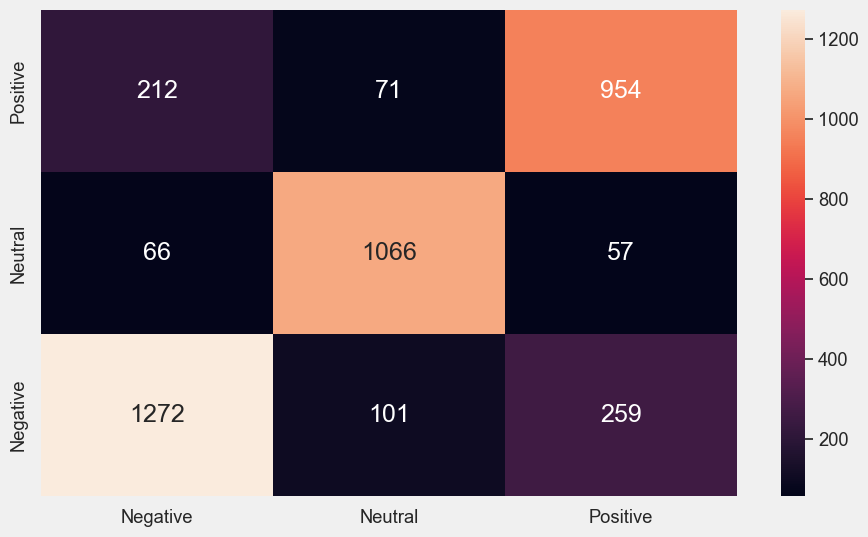

In [91]:
cm_DT = confusion_matrix(y_test, y_pred_DT)

      # neg # neutr  # pos
# pos #  232   65      1397
# neu #  87   1175     51
# neg # 1104   82      321

df_cm_DT = pd.DataFrame(cm_DT, range(3), range(3))
plt.figure(figsize=(10,6))
categories = ['Negative','Neutral','Positive']
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm_DT, annot=True, annot_kws={"size": 18}, xticklabels = categories,
            yticklabels = categories ,fmt="d") # font size
plt.ylim(0, 3)
plt.show()

RANDOM FOREST CLASSIFIER

In [94]:
classifier_RF = RandomForestClassifier()
classifier_RF.fit(X_train, y_train)
y_pred_RF = classifier_RF.predict(X_test)

In [95]:
accuracy_score_RF = accuracy_score(y_test, y_pred_RF)
precision_score_RF = precision_score(y_test, y_pred_RF , average = 'micro')
recall_score_RF = recall_score(y_test, y_pred_RF, average = 'micro')
f1_score_RF = f1_score(y_test, y_pred_RF, average = 'micro')
print("Accuracy Score: " , accuracy_score_RF)
print("Precision Score: " , precision_score_RF)
print("Recall Score: " , recall_score_RF)
print("F1 Score: " , f1_score_RF)

Accuracy Score:  0.8563331690487925
Precision Score:  0.8563331690487925
Recall Score:  0.8563331690487925
F1 Score:  0.8563331690487926


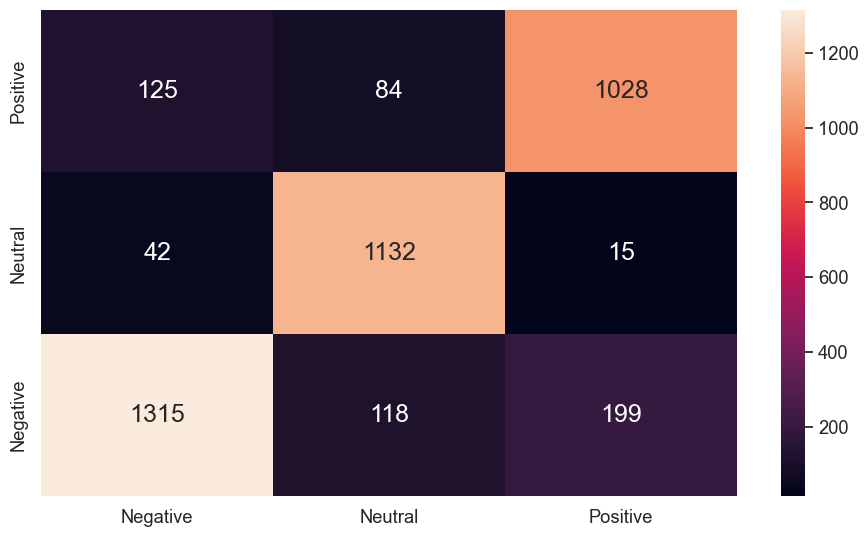

In [96]:
cm_RF = confusion_matrix(y_test, y_pred_RF)

      # neg # neutr  # pos
# pos # 198    92     1404
# neu #  53   1233      27
# neg # 1120   121     266

df_cm_RF = pd.DataFrame(cm_RF, range(3), range(3))
categories = ['Negative','Neutral','Positive']
plt.figure(figsize=(10,6))
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm_RF, annot=True, annot_kws={"size": 18}, xticklabels = categories,
            yticklabels = categories,fmt="d") # font size
plt.ylim(0, 3)
plt.show()

NAIVE BAYES

In [97]:
classifier_NB = MultinomialNB()
classifier_NB.fit(X_train, y_train)
y_pred_NB = classifier_NB.predict(X_test)

In [98]:
accuracy_score_NB = accuracy_score(y_test, y_pred_NB)
precision_score_NB = precision_score(y_test, y_pred_NB , average = 'micro')
recall_score_NB = recall_score(y_test, y_pred_NB, average = 'micro')
f1_score_NB = f1_score(y_test, y_pred_NB, average = 'micro')
print("Accuracy Score: " , accuracy_score_NB)
print("Precision Score: " , precision_score_NB)
print("Recall Score: " , recall_score_NB)
print("F1 Score: " , f1_score_NB)

Accuracy Score:  0.7183341547560375
Precision Score:  0.7183341547560375
Recall Score:  0.7183341547560375
F1 Score:  0.7183341547560373


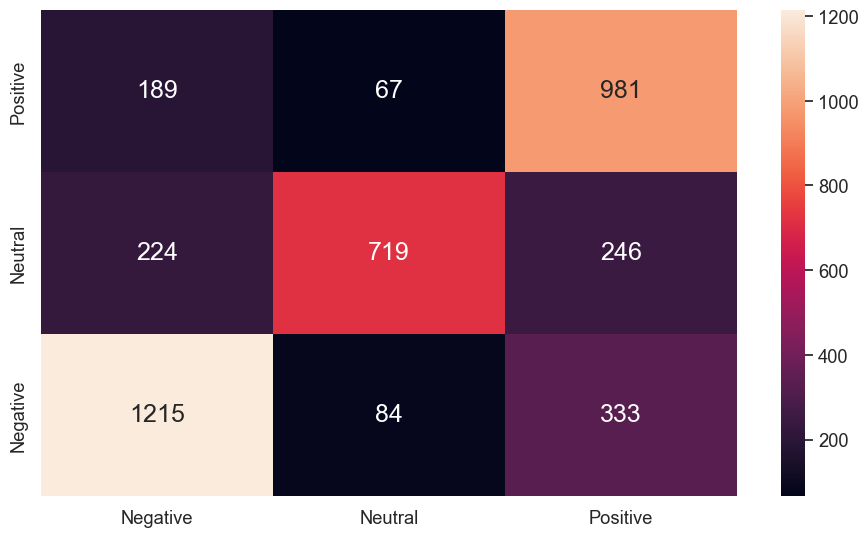

In [99]:
cm_NB = confusion_matrix(y_test, y_pred_NB)

      # neg # neutr  # pos
# pos # 202    133     1359
# neu # 137   931      245
# neg # 1076  160      271

df_cm_NB = pd.DataFrame(cm_NB, range(3), range(3))
plt.figure(figsize=(10,6))
categories = ['Negative','Neutral','Positive']
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm_NB, annot=True, annot_kws={"size": 18}, xticklabels = categories,
            yticklabels = categories,fmt="d") # font size
plt.ylim(0, 3)
plt.show()

COMPARING THE MODELS

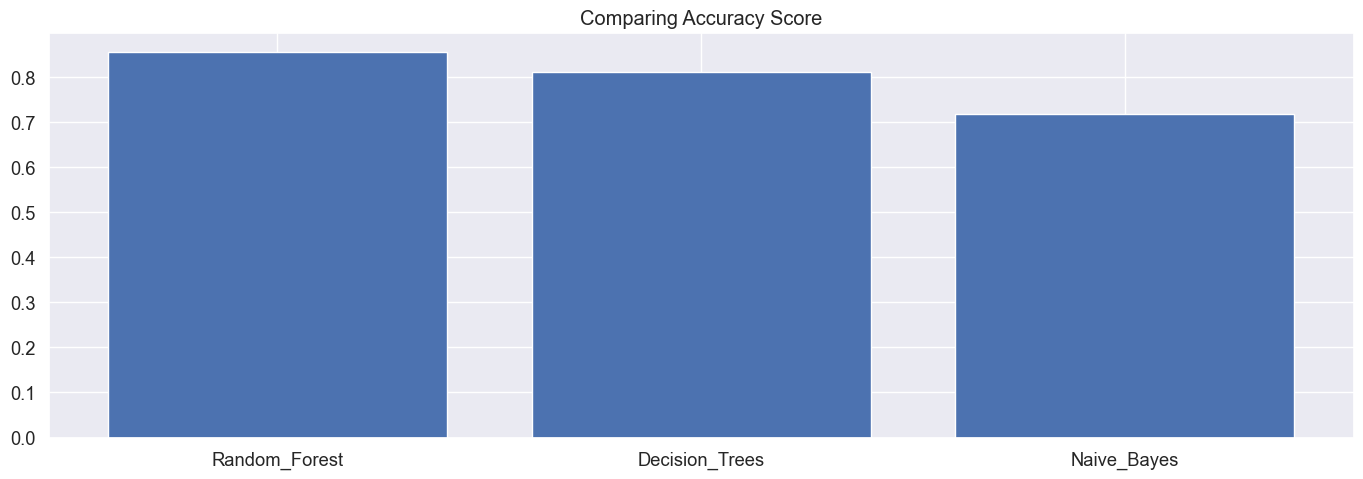

In [100]:
Accuracy = [accuracy_score_RF, accuracy_score_DT, accuracy_score_NB]
Methods = ['Random_Forest', 'Decision_Trees', 'Naive_Bayes']
Accuracy_pos = np.arange(len(Methods))
plt.bar(Accuracy_pos, Accuracy)
plt.xticks(Accuracy_pos, Methods)
plt.title('Comparing Accuracy Score')
plt.show()

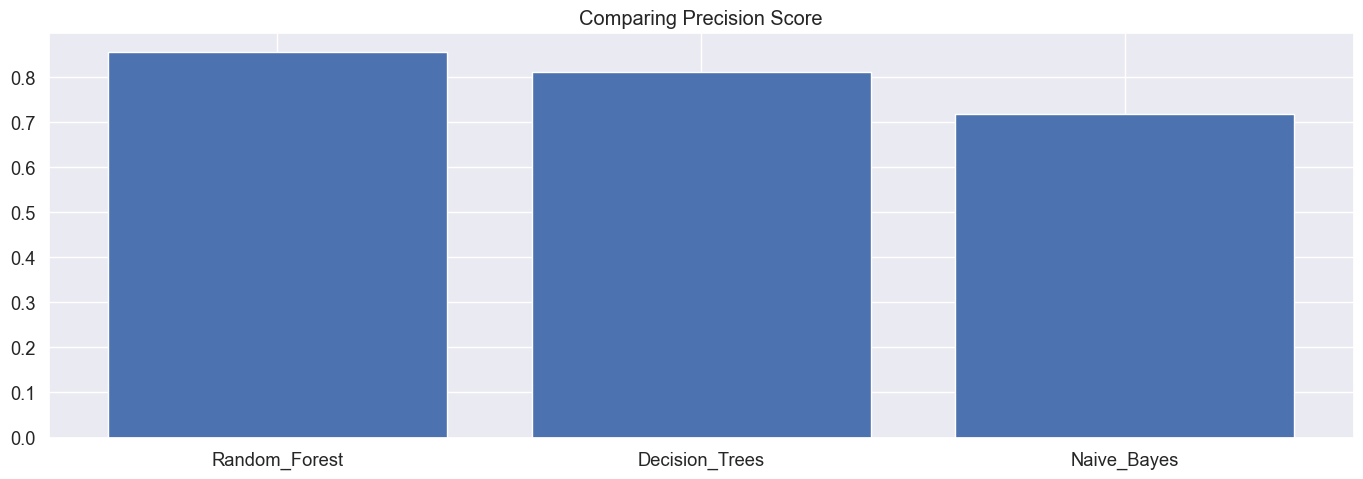

In [101]:
Precision = [precision_score_RF, precision_score_DT, precision_score_NB]
Methods = ['Random_Forest', 'Decision_Trees', 'Naive_Bayes']
Precision_pos = np.arange(len(Methods))
plt.bar(Precision_pos, Precision)
plt.xticks(Precision_pos, Methods)
plt.title('Comparing Precision Score')
plt.show()

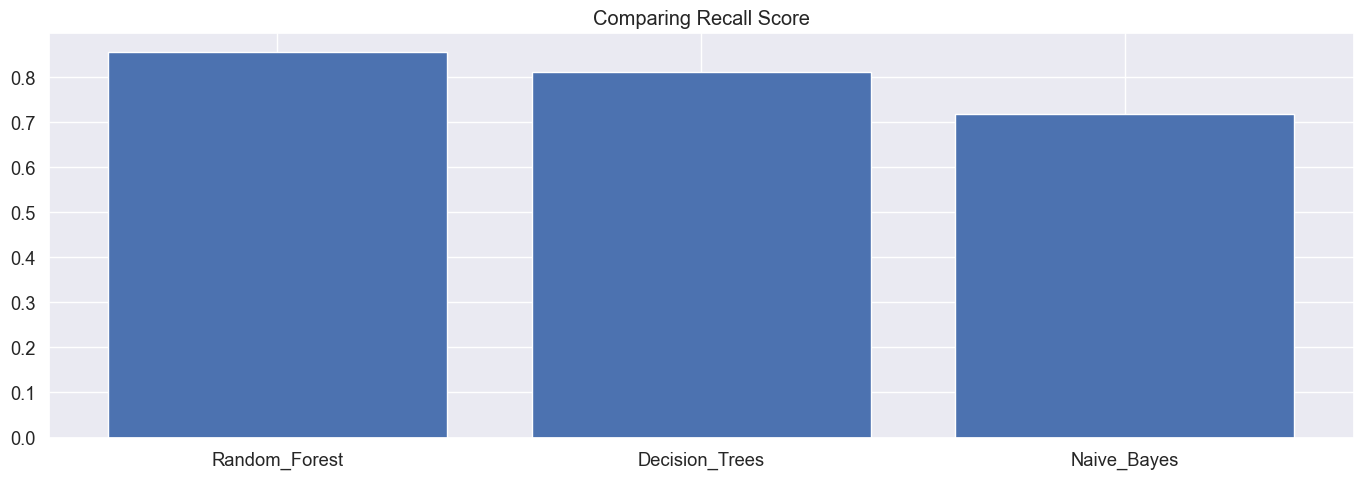

In [102]:
Recall = [recall_score_RF, recall_score_DT, recall_score_NB]
Methods = ['Random_Forest', 'Decision_Trees', 'Naive_Bayes']
Recall_pos = np.arange(len(Methods))
plt.bar(Recall_pos, Recall)
plt.xticks(Recall_pos, Methods)
plt.title('Comparing Recall Score')
plt.show()

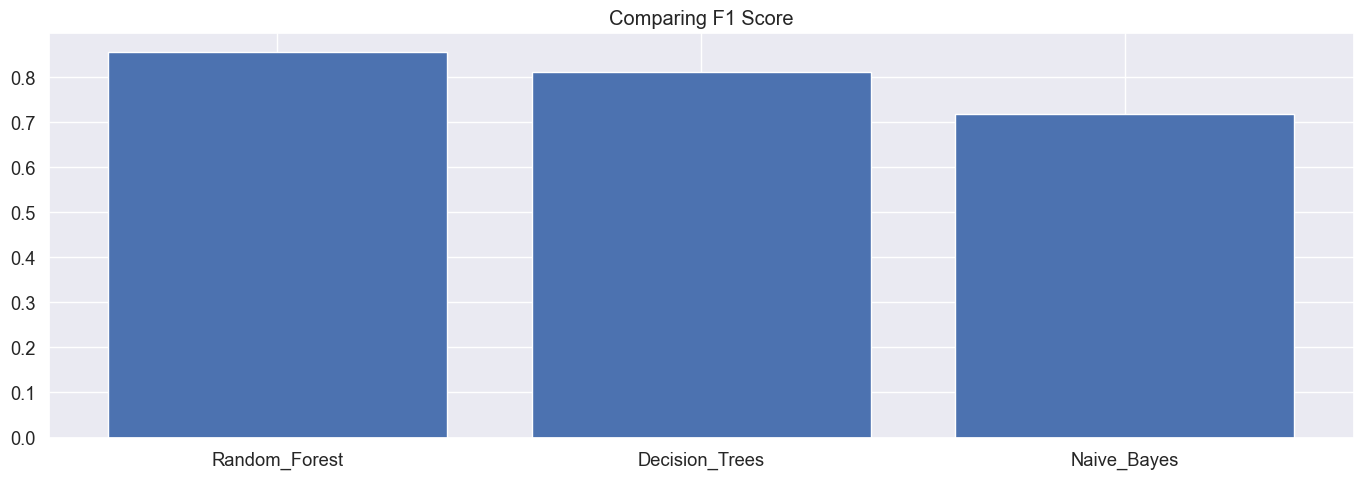

In [103]:
F1 = [f1_score_RF,f1_score_DT,f1_score_NB]
Methods = ['Random_Forest', 'Decision_Trees', 'Naive_Bayes']
F1_pos = np.arange(len(Methods))
plt.bar(F1_pos, F1)
plt.xticks(F1_pos, Methods)
plt.title('Comparing F1 Score')
plt.show()

IT MEANS THAT RANDOM FOREST CLASSIFIER WORKS BEST